# Running GMZ algorithm- demonstration notebook

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import pycomlink as pycml
from math import radians, cos, sin, asin, sqrt
from pyproj import Proj, transform
import scipy.stats as stats
import string
import random
import sys
sys.path.append("../my_functions/")
import iterative_IDW_V1 as gmz

# Generate CMLs

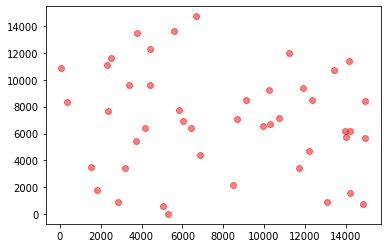

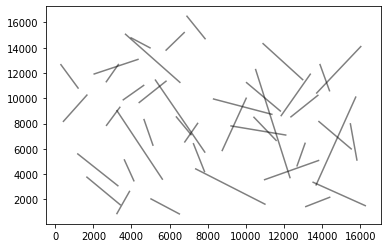

In [5]:
map_res = 300 # map resolution in meters
domain_size = 15.0 # km
links_density = 0.2 # km**-2 
links_mean_length = 2.5 # km
num_of_links = int(np.ceil((domain_size ** 2) * links_density))
links_length_thresh = 4

links_cent = np.random.uniform(low=0.0, high=domain_size*1e3, size=[num_of_links,2]) +\
    np.random.normal(loc=0.0,scale=0.2, size=[num_of_links,2])
# links_lengths = np.squeeze(np.random.exponential(scale=links_mean_length,size=[num_of_links,1]))

# Truncate links' lengths
lower, upper, = 1e3, 10e3
X = stats.truncexpon(b=(upper-lower)/links_mean_length*1e3, 
                     loc=lower, 
                     scale=links_mean_length*1e3)
links_lengths = X.rvs(num_of_links)

fig, ax = plt.subplots()#figsize=(15,10)
ax.plot(links_cent[:,0],links_cent[:,1], 'ro', alpha = 0.5)

#rotation matrix
theta = np.radians(np.random.uniform(low=0.0, high=179.9999, size=[num_of_links,1]))

theta = np.squeeze(theta)
links_xa = (-links_lengths/2)*np.cos(theta) + links_cent[:,0] #+ 672.2919656637181
links_ya = (-links_lengths/2)*np.sin(theta) + links_cent[:,1] #+ 3562.7985050678294
links_xb = (links_lengths/2)*np.cos(theta) + links_cent[:,0] #+ 672.2919656637181
links_yb = (links_lengths/2)*np.sin(theta) + links_cent[:,1] #+ 3562.7985050678294


def link_id_gen(num_of_ids=1, size=8, chars=string.ascii_uppercase + string.digits):
    my_id_list = list()
    for i in range(num_of_links):
        my_id = ''.join(random.choice(chars) for _ in range(size))
        my_id_list.append(my_id[:4] + '-' + my_id[4:])
    return my_id_list

df_cmls = pd.DataFrame(columns= ['Link_num','L','f','Polarization','xa','ya','xb','yb'])
df_cmls['Link_num'] = link_id_gen(num_of_ids=num_of_links)
df_cmls['Polarization'] = np.random.choice(['H', 'V', 'V'], df_cmls.shape[0])
df_cmls['xa'] = links_xa
df_cmls['ya'] = links_ya
df_cmls['xb'] = links_xb
df_cmls['yb'] = links_yb
df_cmls['L'] = links_lengths / 1e3

df_cmls = df_cmls[df_cmls.xa > links_cent[:,0].min() - (domain_size*1e3 * 0.05)]
df_cmls = df_cmls[df_cmls.xb > links_cent[:,0].min() - (domain_size*1e3 * 0.05)]
df_cmls = df_cmls[df_cmls.xa < links_cent[:,0].max() + (domain_size*1e3 * 0.05)]
df_cmls = df_cmls[df_cmls.xb < links_cent[:,0].max() + (domain_size*1e3 * 0.05)]

df_cmls = df_cmls[df_cmls.ya > links_cent[:,1].min() - (domain_size*1e3 * 0.05)]
df_cmls = df_cmls[df_cmls.yb > links_cent[:,1].min() - (domain_size*1e3 * 0.05)]
df_cmls = df_cmls[df_cmls.ya < links_cent[:,1].max() + (domain_size*1e3 * 0.05)]
df_cmls = df_cmls[df_cmls.yb < links_cent[:,1].max() + (domain_size*1e3 * 0.05)]

df_cmls = df_cmls.reset_index(drop=True)

df_cmls['xa'] = df_cmls['xa'] + np.abs(np.min([df_cmls['xa'],df_cmls['xb']])) + map_res
df_cmls['ya'] = df_cmls['ya'] + np.abs(np.min([df_cmls['ya'],df_cmls['yb']])) + map_res
df_cmls['xb'] = df_cmls['xb'] + np.abs(np.min([df_cmls['xa'],df_cmls['xb']])) + map_res
df_cmls['yb'] = df_cmls['yb'] + np.abs(np.min([df_cmls['ya'],df_cmls['yb']])) + map_res

fig, ax = plt.subplots()#figsize=(15,10)
line = ax.plot([df_cmls['xa'],df_cmls['xb']],
                [df_cmls['ya'],df_cmls['yb']],
                'k', alpha=0.5)

# Setting the frequencies by looking at real links' length-frek distribution
rnd_size_temp = len(df_cmls.loc[df_cmls.L > links_length_thresh])
frek_rand_dist_for_long = np.random.uniform(-2,2,rnd_size_temp)

# For long links
for i, idx in enumerate(df_cmls[df_cmls['L'] > links_length_thresh].index):
    df_cmls.loc[idx,'f'] = \
    17 + frek_rand_dist_for_long[i]

rnd_size_temp = len(df_cmls.loc[df_cmls.L <= links_length_thresh])
frek_rand_dist_for_short = np.random.choice([20, 25, 37],size=rnd_size_temp) + \
np.random.uniform(-2,2,rnd_size_temp)
# For short links
for i, idx in enumerate(df_cmls[df_cmls['L'] <= links_length_thresh].index):
    df_cmls.loc[idx,'f'] = \
    frek_rand_dist_for_short[i]

# df_cmls.drop(columns=['Length_aprx'], inplace=True)

In [6]:
df_cmls.head()

,Link_num,L,f,Polarization,xa,ya,xb,yb
0,0NK7-NLUS,1.269223,24.2966,H,12686.770711,4661.419724,13106.480139,6439.319876
1,47Q9-RF8B,5.726810,17.7425,V,7845.458951,5748.245876,5257.474878,11437.014371
2,QDU3-I4F7,2.302861,24.52,V,15826.550885,5119.785911,15484.599746,7977.197763
3,8ENW-B3JC,1.003741,21.9655,V,2681.264152,11308.622786,3312.839356,12668.837002
4,BX04-0HHX,2.369899,20.2223,V,3410.527337,1583.755035,1664.124063,3765.865140


## Assign `a` and `b` parameters from ITU table

In [7]:
for i, cml in df_cmls.iterrows():
    df_cmls.loc[i,'a'], df_cmls.loc[i,'b'] = pycml.processing.A_R_relation.A_R_relation.a_b(
        cml['f'],
        cml['Polarization'])
df_cmls.head()

,Link_num,L,f,Polarization,xa,ya,xb,yb,a,b
0,0NK7-NLUS,1.269223,24.2966,H,12686.770711,4661.419724,13106.480139,6439.319876,0.116317,1.066315
1,47Q9-RF8B,5.726810,17.7425,V,7845.458951,5748.245876,5257.474878,11437.014371,0.052006,1.087484
2,QDU3-I4F7,2.302861,24.52,V,15826.550885,5119.785911,15484.599746,7977.197763,0.108384,1.032866
3,8ENW-B3JC,1.003741,21.9655,V,2681.264152,11308.622786,3312.839356,12668.837002,0.085304,1.049561
4,BX04-0HHX,2.369899,20.2223,V,3410.527337,1583.755035,1664.124063,3765.865140,0.070870,1.063106


## Assign rain intensity values and convert them to attenuation
* GMZ needs to get both the rain intensities (R in mm/h) and the attenuation values (A in dB)

(array([ 7., 12.,  7.,  3.,  3.,  2.,  4.,  1.,  1.,  1.]),
 array([0.9 , 1.54, 2.18, 2.82, 3.46, 4.1 , 4.74, 5.38, 6.02, 6.66, 7.3 ]),
 <BarContainer object of 10 artists>)

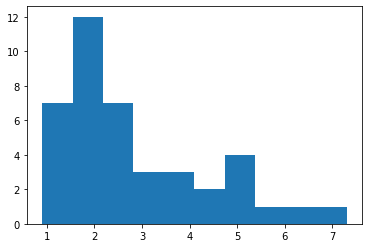

In [8]:
quantization = 0.1 # dB

df_cmls['temp'] = df_cmls['xa'] + df_cmls['ya']
df_cmls = df_cmls.sort_values('temp')
df_cmls.reset_index(inplace=True)
df_cmls['R'] = sorted(np.random.standard_gamma(10.0,len(df_cmls)),reverse=True)
df_cmls['R'].where(df_cmls['R'].values > 0.5,0,inplace=True)
df_cmls['A'] = gmz.apply_power_law(df_cmls['R'],
                                   df_cmls['L'],
                                   df_cmls['a'],
                                   df_cmls['b'])
## Quantize measurements
df_cmls['A'] = round(df_cmls['A'],1)
df_cmls.drop(columns=['temp','index', 'R'], inplace=True)
plt.hist(df_cmls['A'])

### Calculate the rain intensity from the quantized attenuation values

In [9]:
df_cmls['R'] = gmz.apply_inverse_power_law( df_cmls['A'].values,
    df_cmls['L'].values,
    df_cmls['a'].values,
    df_cmls['b'].values)
df_cmls.head()

,Link_num,L,f,Polarization,xa,ya,xb,yb,a,b,A,R
0,5XPY-WJ92,1.343600,21.2915,V,3237.916722,886.663646,3897.057685,2637.553296,0.079604,1.054541,2.1,16.832169
1,BX04-0HHX,2.369899,20.2223,V,3410.527337,1583.755035,1664.124063,3765.865140,0.070870,1.063106,3.3,16.464564
2,ZHQ3-U0SJ,2.852918,21.4328,H,3286.341783,3089.100849,1185.914139,5599.814849,0.087877,1.087797,4.9,15.375543
3,4VMH-A6ZB,1.603897,25.1836,V,6511.323655,860.161253,5026.045553,2045.579109,0.114790,1.028918,2.7,13.598933
4,38IZ-GWFS,1.174396,37.2675,H,4126.169036,3480.200142,3630.539402,5124.966884,0.301448,0.960472,4.2,13.135057


# Generate a grid

In [10]:
y_min = min(df_cmls['ya'].min(), df_cmls['yb'].min()) - map_res
y_max = max(df_cmls['ya'].max(), df_cmls['yb'].max()) + map_res
x_min = min(df_cmls['xa'].min(), df_cmls['xb'].min()) - map_res
x_max = max(df_cmls['xa'].max(), df_cmls['xb'].max()) + map_res

x = np.arange(x_min, x_max, map_res) 
y = np.arange(y_min, y_max, map_res) 

X, Y = np.meshgrid(x, y)
Y

array([[  560.16125346,   560.16125346,   560.16125346, ...,
          560.16125346,   560.16125346,   560.16125346],
       [  860.16125346,   860.16125346,   860.16125346, ...,
          860.16125346,   860.16125346,   860.16125346],
       [ 1160.16125346,  1160.16125346,  1160.16125346, ...,
         1160.16125346,  1160.16125346,  1160.16125346],
       ...,
       [16160.16125346, 16160.16125346, 16160.16125346, ...,
        16160.16125346, 16160.16125346, 16160.16125346],
       [16460.16125346, 16460.16125346, 16460.16125346, ...,
        16460.16125346, 16460.16125346, 16460.16125346],
       [16760.16125346, 16760.16125346, 16760.16125346, ...,
        16760.16125346, 16760.16125346, 16760.16125346]])

# Create virtual gauges for each cml
note that before applying GMZ the values of all virtual rain gauges (`z`) are the same

In [11]:
num_of_vg = 5 # number of virtual gauges per cml

df_prep_gmz, _ = gmz.create_virtual_gauges(
                        df_cmls,
                        num_gauges=num_of_vg)
df_prep_gmz.head()

,Link_num,L,f,Polarization,xa,ya,xb,yb,a,b,A,R,x,y,z
0,5XPY-WJ92,1.343600,21.2915,V,3237.916722,886.663646,3897.057685,2637.553296,0.079604,1.054541,2.1,16.832169,"(3347.7735492993634, 3457.6303764943405, 3567....","(1178.4785875159444, 1470.2935292280918, 1762....","(16.832168572095387, 16.832168572095387, 16.83..."
1,BX04-0HHX,2.369899,20.2223,V,3410.527337,1583.755035,1664.124063,3765.865140,0.070870,1.063106,3.3,16.464564,"(3119.4601247300325, 2828.392912470623, 2537.3...","(1947.4400522931423, 2311.1250698663835, 2674....","(16.464564362323877, 16.464564362323877, 16.46..."
2,ZHQ3-U0SJ,2.852918,21.4328,H,3286.341783,3089.100849,1185.914139,5599.814849,0.087877,1.087797,4.9,15.375543,"(2936.270509313754, 2586.1992353019086, 2236.1...","(3507.5531826490324, 3926.005515853851, 4344.4...","(15.375543292696618, 15.375543292696618, 15.37..."
3,4VMH-A6ZB,1.603897,25.1836,V,6511.323655,860.161253,5026.045553,2045.579109,0.114790,1.028918,2.7,13.598933,"(6263.77730480466, 6016.230954405658, 5768.684...","(1057.7308960214461, 1255.3005385800457, 1452....","(13.598932905229827, 13.598932905229827, 13.59..."
4,38IZ-GWFS,1.174396,37.2675,H,4126.169036,3480.200142,3630.539402,5124.966884,0.301448,0.960472,4.2,13.135057,"(4043.5640966441674, 3960.959157647771, 3878.3...","(3754.3279325041717, 4028.4557227617124, 4302....","(13.135056626219383, 13.135056626219383, 13.13..."


## Initiate GMZ: calculate weights and store them with the object `cml_interp_gmz`
Setting `max_iter` to 1 will make the object ino a non-iterative IDW interpolator

In [12]:
roi = 20.0e3 # Radius of Influence in meters (parameter of IDW interpolation)
max_iter = 28 # maximal number of iterations in GMZ
Tol = 0.0001 # tolerance
shepard_or_cressman = 0 # 0-shep. 1-cress. Choose the weighting function. 
# 0 is recommended for rain

cml_interp_gmz = gmz.IdwIterative(df_prep_gmz,
                              X,
                              Y,
                              roi, 
                              max_iter, 
                              Tol, 
                              shepard_or_cressman)


Calculation of weights finished


### Another option is to differentiate between the ROI of the weighting of GMZ and the ROI of the IDW interpolation afterwards


In [13]:
cml_interp_gmz_d = gmz.IdwIterative(df_prep_gmz,
                              X,
                              Y,
                              roi, 
                              max_iter, 
                              Tol, 
                              shepard_or_cressman,
                               fixed_gmz_roi=10e3)

Calculation of weights finished


## Call GMZ and interpolate with IDW

In [14]:
algo_out = cml_interp_gmz(df_prep_gmz, 
                          quantization=quantization)

algo_out_d = cml_interp_gmz_d(df_prep_gmz, 
                          quantization=quantization)

Interpolating

Processing finished.

Interpolating

Processing finished.



### Check the descent `dz`

Text(0, 0.5, 'dZ (mm/h)')

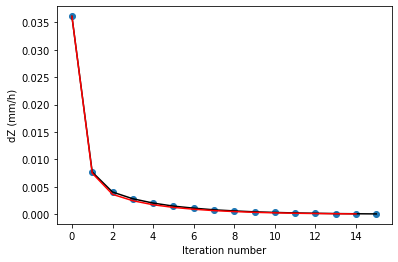

In [15]:
plt.scatter(range(len(cml_interp_gmz.dz_vec)),cml_interp_gmz.dz_vec)
plt.plot(range(len(cml_interp_gmz.dz_vec)),cml_interp_gmz.dz_vec, color='k')
plt.plot(range(len(cml_interp_gmz_d.dz_vec)),cml_interp_gmz_d.dz_vec, color='r')
plt.xlabel('Iteration number')
plt.ylabel('dZ (mm/h)')

## Visualization of the final product

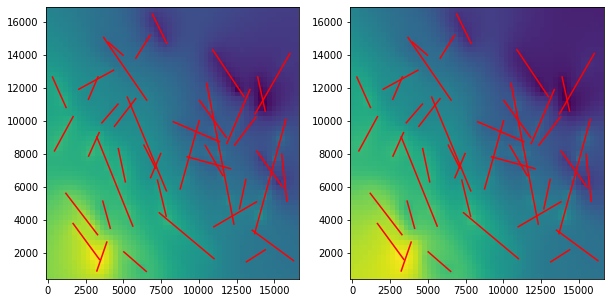

In [20]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].pcolormesh(X,Y,algo_out,shading='auto')
lines = ax[0].plot([df_cmls['xa'],df_cmls['xb']],
                 [df_cmls['ya'],df_cmls['yb']],
               color='r')
ax[1].pcolormesh(X,Y,algo_out_d,shading='auto')
lines = ax[1].plot([df_cmls['xa'],df_cmls['xb']],
                 [df_cmls['ya'],df_cmls['yb']],
               color='r')